# Laying out a seismic survey

This notebook goes with a blog post — [Laying out a seismic survey](http://agilegeoscience.com/journal/2014/12/17/laying-out-a-seismic-survey.html) — on Wednesday 17 December 2014. 

We start with the usual preliminaries...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopandas import GeoDataFrame

%matplotlib inline

## Set up a basic geometry

Next we can define the survey parameters.

In [2]:
# initial conditions
xmi = 575000   # leftmost corner of grid (m)
ymi= 4710000   # bottommost corner of grid (m)
SL = 600       # shot line interval (m)
RL = 600       # receiver line interval (m)
si = 100       # source point interval (m)
ri = 100       # receiver interval (m)
x = 3000       # width of survey (m)
y = 1800       # height of survey (m)

Some easy geometry: calculate the number of source and receiver lines we can fit into the shape we have defined, given the spacing we want:

In [3]:
# Number of receiver lines and source lines
rlines = int(y/RL) + 1
slines = int(x/SL) + 1

# Put recevier lines East-West, and shot lines North South
rperline = int(x/ri) + 2
sperline = int(y/si) + 2

# offset the receivers relative to the sources
shiftx = -si/2.
shifty = -ri/2.

This is a double list comprehension. It's a bit sticky. First, to illustrate the point, see how this one-liner makes a simple list:

In [4]:
[x**2 for x in range(10)]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

Now check this out:

In [5]:
[x**y for x in range(4) for y in range(4)]

[1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 4, 8, 1, 3, 9, 27]

Now hopefully it's not too hard to see what we're doing here...

In [6]:
# Find x,y coordinates of recs and shots
rcvrx = [xmi + rcvr*ri + shiftx for line in range(rlines) for rcvr in range(rperline)]
rcvry = [ymi + line*RL - shifty for line in range(rlines) for rcvr in range(rperline)]

srcx = [xmi + line*SL for line in range(slines) for src in range(sperline)]
srcy = [ymi + src*si for line in range(slines) for src in range(sperline)] 

In [7]:
def plot_geoms(xcoords, ycoords, color = 'none', size = 50, alpha = 0.5):
    """
    A helper function to make it a bit easier to plot multiple things.
    """
    plot = plt.scatter(xcoords,
                       ycoords, 
                       c=color, 
                       s=size,
                       marker='o',
                       alpha=alpha,
                       edgecolor='none'
                       )
    return plot

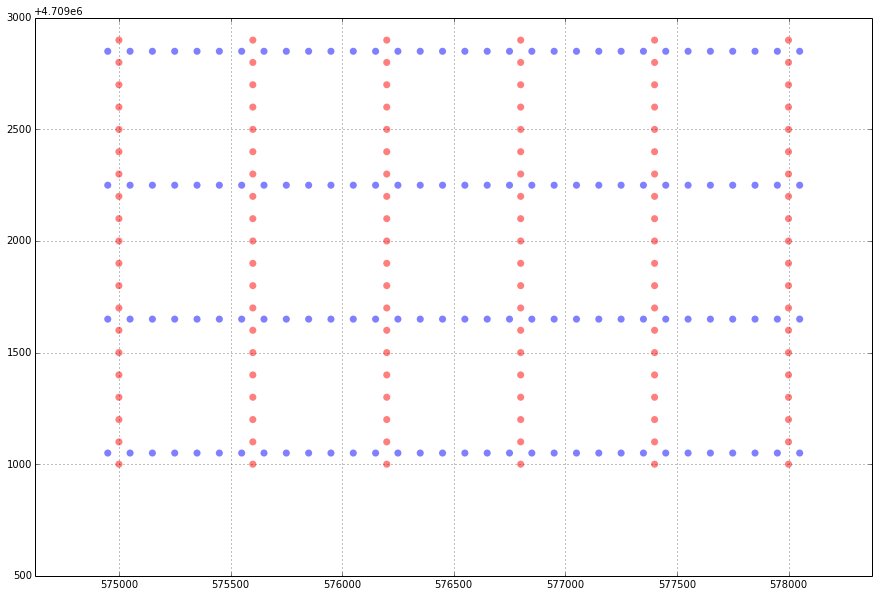

In [8]:
fig = plt.figure(figsize=(15,10))
r = plot_geoms(rcvrx, rcvry, 'b')
s = plot_geoms(srcx, srcy, 'r')
plt.axis('equal')
plt.grid()

## Making a more robust data container

In [9]:
# Zip into x,y coordinate pairs.
rcvrxy = zip(rcvrx, rcvry)
srcxy = zip(srcx, srcy)

# Create a list of Point objects.
rcvrs = [Point(x,y) for x,y in rcvrxy]
srcs = [Point(x,y) for x,y in srcxy]

# Put lists into a GeoDataFrame.
receivers = GeoDataFrame({'geometry': rcvrs})
sources = GeoDataFrame({'geometry': srcs})

If you want to, save the `GeoDataFrame`s as shapefiles:

In [10]:
sources.to_file('sources.shp')
receivers.to_file('receivers.shp')

## Computing the midpoints

We're going to need Shapely's `LineString` geometry — essentially we ask for the 50% (0.5) mark along a line interpolated between two `Point` objects. The `interpolate` method returns another `Point`.

In [11]:
from shapely.geometry import LineString

Another nested list comp gets the job done. Python is awesome!

In [12]:
midpoints = [LineString([r, s]).interpolate(0.5, normalized=True) for r in rcvrs for s in srcs]

We won't get into this too much right now, but let's just check we got what we wanted. We can throw the midpoints into a GeoPandas `GeoSeries` object, essentially a 1D GeoDataFrame — a bit like a 1D labelled array — then use its built-in `plot` method.

In [13]:
from geopandas import GeoSeries

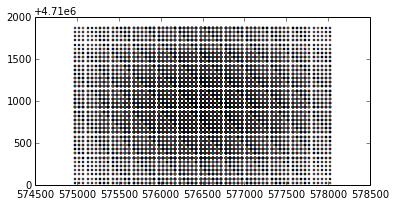

In [14]:
m = GeoSeries(midpoints)
m.plot()

Voilà!